# **Network Exploration**

## **Imports**

In [1]:
import os
import sys
from pathlib import Path
from warnings import filterwarnings
from dotenv import load_dotenv
import tweepy
import numpy as np
import pandas as pd
import ast
from scipy.stats import gmean
import networkx as nx
import matplotlib.pyplot as plt
from main import get_user_description, get_user_ids


load_dotenv()
filterwarnings("ignore")

PATH = os.getcwd()
PROJECT = str(Path(PATH).parents[1])
TWITTER_USERNAME = os.getenv("TWITTER_USERNAME")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_API_BEARER_TOKEN = os.getenv("TWITTER_API_BEARER_TOKEN")

client = tweepy.Client(TWITTER_API_BEARER_TOKEN, wait_on_rate_limit=True)

In [18]:
def draw_graph(
    graph=None,
    edge_labels=None,
    pos=None,
    edge_color="black",
    width=1,
    linewidths=1,
    node_size=3500,
    node_color="black",
    alpha=0.9,
    font_color="w",
    font_size=16,
    fig_size=(20, 20),
    length=17,
    edge_label_font_color="red",
    title=None,
):
    """
    takes a graph and edge labels and draws a diagram. You need to pass edge labels
    if you are passing a graph parameters.
    For smaller subgraphs pass nx.circular_layout for pos.
    """

    if pos == None:
        pos = nx.spring_layout(graph)
    else:
        pos = pos
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title)
    nx.draw(
        graph,
        pos=pos,
        edge_color=edge_color,
        width=width,
        linewidths=linewidths,
        node_size=node_size,
        node_color=node_color,
        alpha=alpha,
        font_color=font_color,
        font_size=font_size,
        labels={node: node for node in graph.nodes()},
    )

    nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels=edge_labels,
        font_color=edge_label_font_color,
        font_size=font_size,
    )
    plt.axis("off")
    plt.show()

def get_ego_graph(graph, edge_labels=None, node="Tom", radius=1):
    ego_graph = nx.ego_graph(graph, n=node, radius=radius)
    ego_edge_labels = dict()
    ego_node_labels = {node: node for node in ego_graph.nodes()}
    ego_edge_labels = dict()
    if edge_labels:
        keys = edge_labels.keys()
        for key in keys:
            if key in ego_graph.edges():
                ego_edge_labels[key] = edge_labels[key]
    return ego_graph, ego_edge_labels, 

## **Read**

In [2]:
df = pd.read_csv("data/users_followers.csv")
df.following = df.following.apply(ast.literal_eval)
df.head()

,user,following
0,1210565171107815429,"[1281443510, 632966383, 27631809, 14922097, 22..."
1,3432386097,"[33836629, 188343397, 235684766, 17268874, 439..."
2,1120633726478823425,[]
3,4398626122,[]
4,48008938,"[1464797992872034304, 630995607, 27493883, 123..."


In [3]:
df = df.explode('following')
df.user.value_counts()[:20]

17230018               5000
2261210518             5000
2228878592             5000
12609292               5000
1263491240336769026    5000
24306387               4953
21862217               4879
1398479138             4636
12                     4550
232294292              4538
18208354               3870
939543286582317056     3784
17136315               3722
289548939              3608
3380357519             3141
16047950               2704
26637348               2540
11740902               2511
134976379              2260
2467726476             2258
Name: user, dtype: int64

## **Graph and Measures**

In [5]:
edges = df.copy().dropna()
edges.columns = ['source', 'target']
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)

In [6]:
G = nx.from_pandas_edgelist(
    edges,
    create_using=nx.DiGraph(),
)

In [14]:
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
print(f"Average Clustering: {round(nx.average_clustering(G), 3)}")

Nodes: 101747, Edges: 138010
Average Clustering: 0.076


elonmusk
Nodes: 114, Edges: 319
Average Clustering: 0.559


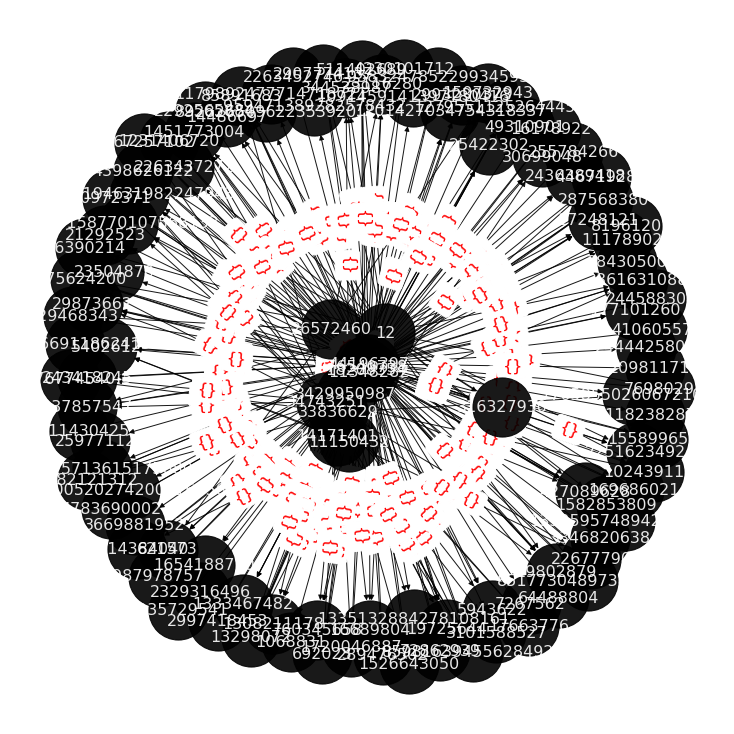

ImHardcory
Nodes: 723, Edges: 2094
Average Clustering: 0.474


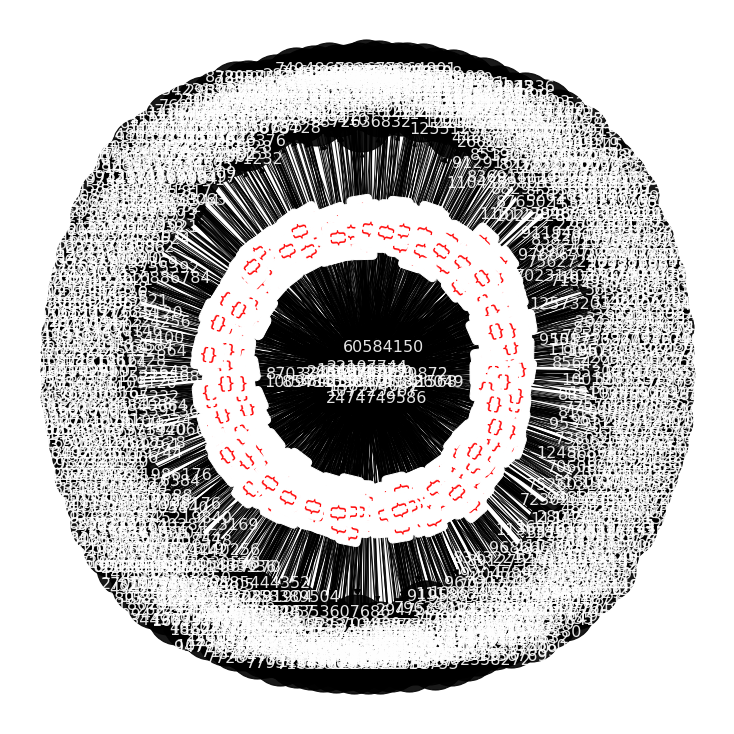

engineers_feed
Nodes: 42, Edges: 85
Average Clustering: 0.334


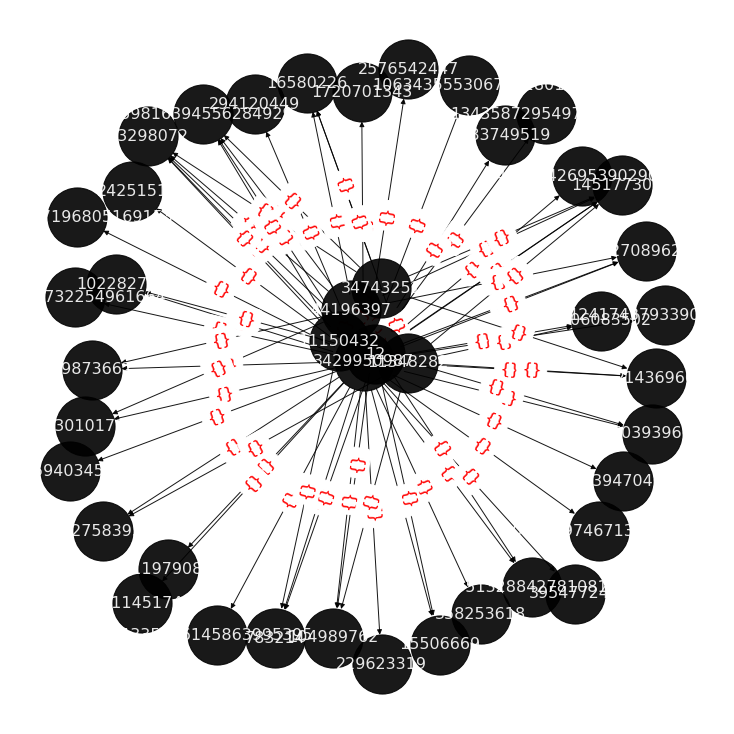

karpathy
Nodes: 678, Edges: 1101
Average Clustering: 0.34


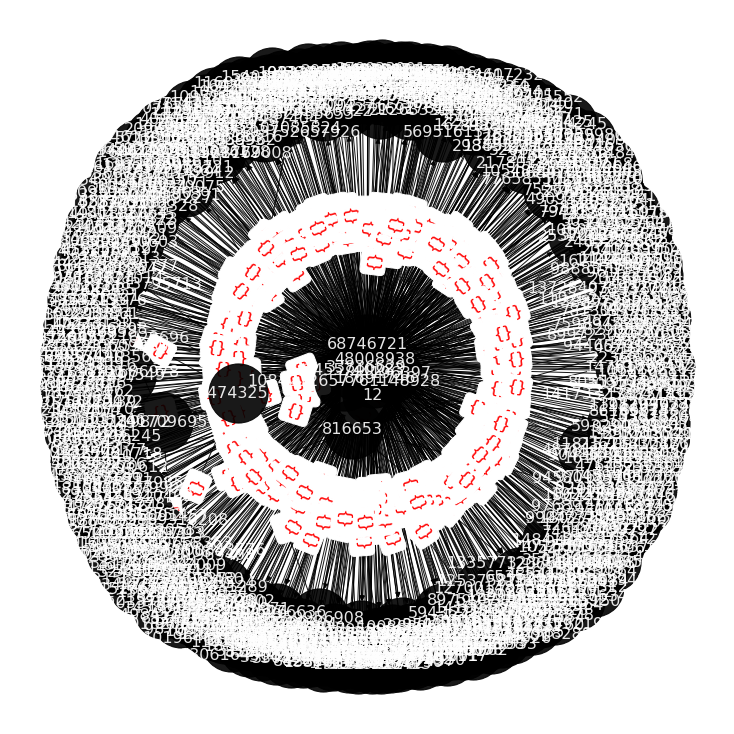

kiraincongress
Nodes: 139, Edges: 138
Average Clustering: 0.0


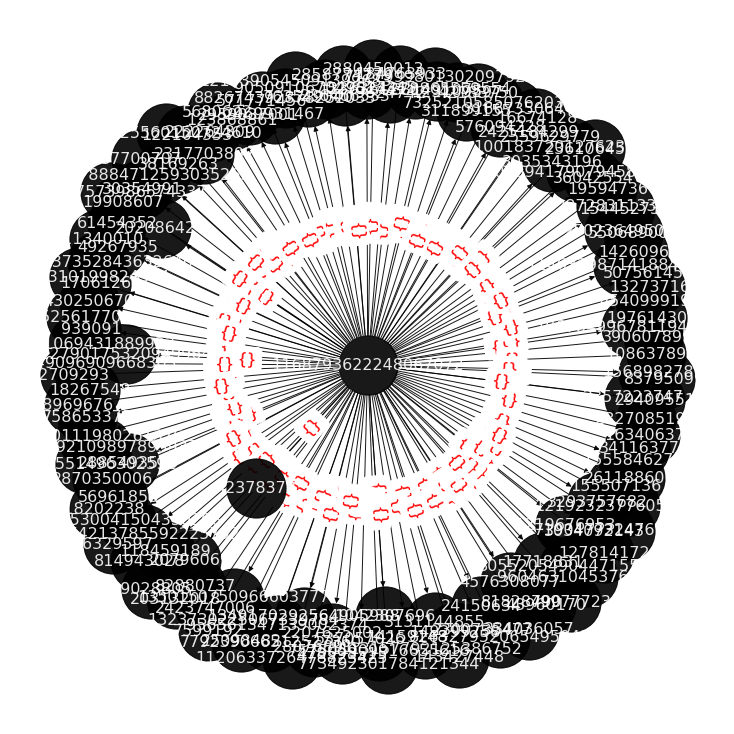

In [34]:
# user_ids = [620047515, 3380357519]
# print(get_user_description(user_ids))
user_names = ['elonmusk', 'ImHardcory', 'engineers_feed', 'karpathy', 'kiraincongress']
user_ids = get_user_ids(user_names)

for i, user_id in enumerate(user_ids):
    G_s, _ = get_ego_graph(G, node=user_id)
    print(f"{user_names[i]}")
    print(f"Nodes: {len(G_s.nodes())}, Edges: {len(G_s.edges())}")
    print(f"Average Clustering: {round(nx.average_clustering(G_s), 3)}")
    # print(f"Small Worldness (>=1): {round(nx.algorithms.smallworld.sigma(G_s.to_undirected(), niter = 5), 3)}"): #takes forever
    draw_graph(G_s, fig_size  = (10, 10))

## **Ranking: Directly using Centrality Metrics**

In [64]:
c_ev = nx.eigenvector_centrality(G) #Katz is better, settling because it takes forever and doesnt converge
c_ev = sorted(c_ev.items(), key=lambda x: x[1], reverse=True)
c_cl = nx.closeness_centrality(G)
c_cl = sorted(c_cl.items(), key=lambda x: x[1], reverse=True)

In [80]:
top_n = 200
df_ev = pd.DataFrame(c_ev[:top_n], columns = ['user', 'cen_ev'])
df_cl = pd.DataFrame(c_cl[:top_n], columns = ['user', 'cen_cl'])
df_cen = df_ev.merge(df_cl, how='inner')
df_cen['rank_cen_ev'] = df_cen['cen_ev'].rank(pct=True)
df_cen['rank_cen_cl'] = df_cen['cen_cl'].rank(pct=True)

df_cen['rank_combined'] = df_cen.iloc[:, -2:].apply(gmean, axis=1)
df_cen['username'] = df_cen['user'].apply(lambda x: get_user_description(x))
df_cen.sort_values(by='rank_combined', ascending = False, inplace=True)

df_cen[~df_cen.user.isin(df.user.unique())].head(25) #not already following

,user,cen_ev,cen_cl,rank_cen_ev,rank_cen_cl,rank_combined,username
0,116994659,0.070487,0.000579,1.000000,0.965116,0.982403,[Sam Harris:SamHarrisOrg]
1,106204123,0.070008,0.000554,0.988372,0.895349,0.940711,[Jonathan Haidt:JonHaidt]
10,15143478,0.054532,0.000538,0.883721,0.837209,0.860151,[Richard Dawkins:RichardDawkins]
27,5943622,0.048151,0.000570,0.686047,0.941860,0.803841,[Marc Andreessen:pmarca]
4,88315048,0.060135,0.000503,0.953488,0.639535,0.780890,[Coleman Hughes:coldxman]
14,1306199515,0.052479,0.000510,0.837209,0.709302,0.770607,[John McWhorter:JohnHMcWhorter]
13,16076032,0.052563,0.000503,0.848837,0.639535,0.736791,[Glenn Greenwald:ggreenwald]
18,17995040,0.051486,0.000507,0.790698,0.686047,0.736516,[Ben Shapiro:benshapiro]
6,15912890,0.057500,0.000492,0.930233,0.523256,0.697674,[Ayaan Hirsi Ali:Ayaan]
37,2916305152,0.043282,0.000528,0.569767,0.808140,0.678566,[Edward Snowden:Snowden]


#### **TODO**
- [ ] Eigenvector centrality matters more, consider weighted mean
- [ ] Node features
- [ ] :Consideration: Tweet content paired with ideal prompts in the embedding space
- [ ] :Consideration: Outliers | Downweight certain recommendations?
- [ ] GNNs

## **Play with Torch**

In [4]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

`data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

`data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type torch.long

`data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

`data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

`data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

In [5]:
print(data.keys)
print(data['x'])

['edge_index', 'x']
tensor([[-1.],
        [ 0.],
        [ 1.]])


In [6]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = GCNConv(dataset.num_node_features, 16)
        self.conv_2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv_1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training = self.training)
        x = self.conv_2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8020


## Appendix

In [78]:
# nt = Network('500px', '500px')
# nt.from_nx(G)
# nt.show('nx.html')
# client.destroy_friendship(?) #dont need no api for that! hold my beer!